[View in Colaboratory](https://colab.research.google.com/github/MPCE/mpce-machine-learning/blob/master/mpce_neural_nets.ipynb)

# Mapping Print, Charting Enlightenment

## Machine Learning Experiment 1: Classifying books by titles and other metadata

Team: Rachel Hendery, Tomas Trescak, Katie McDonough, Michael Falk, Simon Burrows

## Notebook 3: Training a Neural Net on title vector data

Author: Michael Falk

Having converted each title into a 300-dimesnional mean word vector, here train a deep neural network using TensorFlow.

You will need to upload title_vector_data.p from project repo in order to run this code.

### 3.1 Import and reshape the data
In a previous notebook, the titles were converted into 300-dimensional word vectors using Facebook's pretrained FastText models. These word vectors were then pickled for later use. The first thing is to import the pickled data and reshape it for our purposes.

In [0]:
#Import key libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pickle
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import itertools
from sklearn import metrics
from sklearn.model_selection import train_test_split
import time

In [75]:
# Import data
data = pickle.load(open("title_vector_data.p", "rb"))
X = data["X"]
y_str = data["y"]

# Map labels in y_str to numbers
labels = dict([(y,x) for x,y in enumerate(sorted(y_str.unique().tolist()))]) # map labels to integers
y_num = np.asarray([labels[x] for x in y_str], dtype=np.int8) # map y to the numbers

# Convert y to a one-hot matrix
num_classes = y_str.nunique()
num_examples = y_str.shape[0]
y = np.zeros((num_examples, num_classes))
y[np.arange(num_examples), y_num] = 1

# Examine data
print ("X is an " + str(type(X).__name__) + " with dimensions " + str(X.shape))
print ("y is an " + str(type(y).__name__) + " with dimensions " + str(y.shape))

X is an ndarray with dimensions (3824, 300)
y is an ndarray with dimensions (3824, 6)


In [92]:
# Split the train, dev and test sets (60% train, 20% dev, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.4)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size = 0.5)
print ("X_train is an " + str(type(X_train).__name__) + " with dimensions " + str(X_train.shape))
print ("y_train is an " + str(type(y_train).__name__) + " with dimensions " + str(y_train.shape))
print ("X_dev is an " + str(type(X_dev).__name__) + " with dimensions " + str(X_dev.shape))
print ("y_dev is an " + str(type(y_dev).__name__) + " with dimensions " + str(y_dev.shape))
print ("X_test is an " + str(type(X_test).__name__) + " with dimensions " + str(X_test.shape))
print ("y_test is an " + str(type(y_test).__name__) + " with dimensions " + str(y_test.shape))

X_train is an ndarray with dimensions (2294, 300)
y_train is an ndarray with dimensions (2294, 6)
X_dev is an ndarray with dimensions (765, 300)
y_dev is an ndarray with dimensions (765, 6)
X_test is an ndarray with dimensions (765, 300)
y_test is an ndarray with dimensions (765, 6)


### 3.2 Define function for displaying confusion matrix

In [0]:
def plot_confusion_matrix(model, X, Y, labels,
                          normalize=True,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    params:
    model = trained model with predict method
    X = matrix with examples stacked in rows
    Y = one-hot matrix of class assignments
    labels = dict of class labels, in the form label:integer. 
    """
    # Need to convert results from one-hot matrix to class numbers
    predictions = model.predict(X) # make predictions on dev set
    predictions = np.argmax(predictions, axis = 1) # convert to 1d array
    true = np.argmax(Y, axis = 1) # convert true values to 1d array

    # Calculate the confusion matrix
    cm = metrics.confusion_matrix(true, predictions)
    
    # Normalise the results as appropriate
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Confusion matrix (normalised)'
    else:
        title = 'Confusino matrix (raw)'

    # Get class labels in right order
    classes = sorted(labels, key=labels.get)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 3.3 Train the first neural net
Now that the data is in good shape, we can set up the neural network and train it. I have opted to use the simple, high-level Keras API for this task.

Model trained with no regularisation. Training took 105.098 seconds.


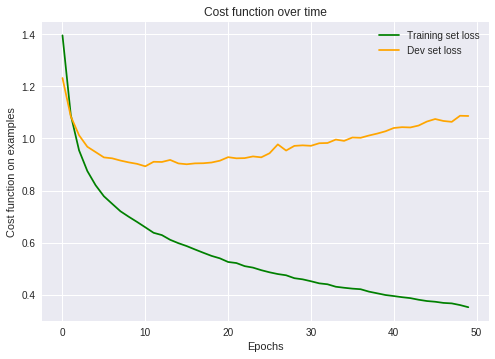

In [273]:
# Initialise model
model1 = keras.Sequential()

# Add five hidden layers
num_hidden = 1
for l in range(num_hidden):
  model1.add(keras.layers.Dense(30, activation='relu'))

# Add output layer
model1.add(keras.layers.Dense(num_classes, activation='softmax'))

# Choose optimisation function
model1.compile(optimizer=tf.train.AdamOptimizer(0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# Train model on training set using batch Adam
num_epochs = 50
fit1 = model1.fit(X_train, y_train,
          epochs = num_epochs, # Do 50 iterations
          batch_size = None, # Use default
          validation_data = (X_dev, y_dev), # Validate against dev set
          verbose = 0 # suppress messages
         )

# Display training curves
plt.plot(fit1.history['loss'], color = 'g', label = "Training set loss")
plt.plot(fit1.history['val_loss'], color = 'orange', label = "Dev set loss")
plt.title("Loss function over time")
plt.xlabel('Epochs')
plt.ylabel('Loss on examples')
plt.legend()
print(f"Model trained with no regularisation. Training took {end - start:.3f} seconds.")

Training accuracy after 50 epochs was 0.888
Dev set accuracy after 50 epochs was 0.706


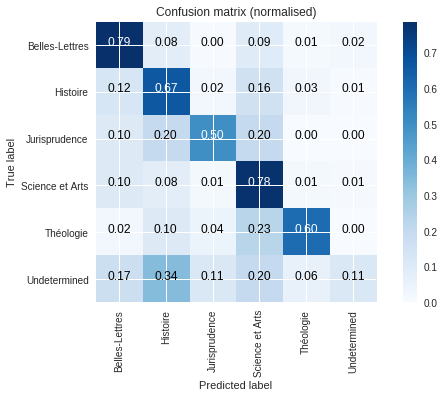

In [275]:
# Examine how well the model did:
training_acc = fit1.history['acc'][-1]
val_acc = fit1.history['val_acc'][-1]
print(f"Training accuracy after {num_epochs} epochs was {training_acc:.3f}")
print(f"Dev set accuracy after {num_epochs} epochs was {val_acc:.3f}")
plot_confusion_matrix(model1, X_dev, y_dev, labels)

### 3.4 Stop the model from overfitting
The model quite rapidly converges on a good solution for the training data, but it is overfitting and only achieving an accuracy of 70% on the dev data. Let's try some regularisation methods and see if they work.

Model trained with L2 regularisation. Training took 105.098 seconds.


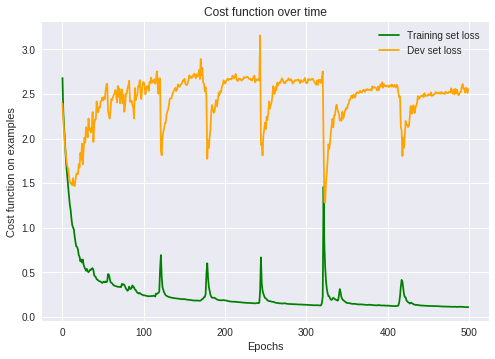

In [267]:
# Initialise new model
model_L2 = keras.Sequential()

# Set hyperparameters
num_hidden = 10
layer_size = 100
L2_lambda = 0.001
learning_rate = 0.001

# Generate hidden layers
for l in range(num_hidden):
  model_L2.add(keras.layers.Dense(layer_size,
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(l=L2_lambda)))

# Add output layer
model_L2.add(keras.layers.Dense(num_classes, activation='softmax'))

# Choose optimisation function
model_L2.compile(optimizer=tf.train.AdamOptimizer(learning_rate),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# Train
start = time.perf_counter()
num_epochs = 500
fit_L2 = model_L2.fit(X_train, y_train,
          epochs = num_epochs,
          batch_size = 200,
          validation_data = (X_dev, y_dev),
          verbose = 0
         )
end = time.perf_counter()

# Display training curves
plt.plot(fit_L2.history['loss'], color = 'g', label = "Training set loss")
plt.plot(fit_L2.history['val_loss'], color = 'orange', label = "Dev set loss")
plt.title("Loss function over time")
plt.xlabel('Epochs')
plt.ylabel('Loss on examples')
plt.legend()
print(f"Model trained with L2 regularisation. Training took {end - start:.3f} seconds.")

There were 10 hidden layers of size 100.
Lambda was set to 0.001. The learning rate was 0.001.

Training accuracy after 500 epochs was 0.997.
Dev set accuracy after 500 epochs was 0.630.

This is an improvement of -0.071 over the first model.



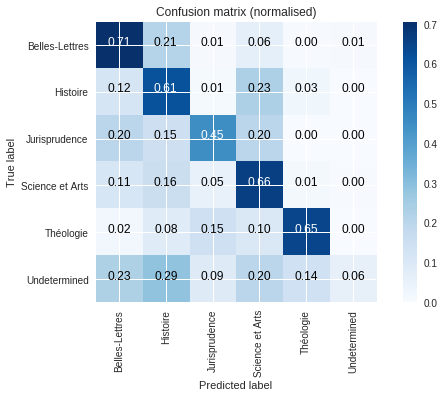

In [269]:
# Examine how well the model did:
new_training_acc = fit_L2.history['acc'][-1]
new_val_acc = fit_L2.history['val_acc'][-1]
print(f"There were {num_hidden} hidden layers of size {layer_size}.")
print(f"Lambda was set to {L2_lambda}. The learning rate was {learning_rate}.\n")
print(f"Training accuracy after {num_epochs} epochs was {new_training_acc:.3f}.")
print(f"Dev set accuracy after {num_epochs} epochs was {new_val_acc:.3f}.\n")
print(f"This is an improvement of {new_val_acc - val_acc:.3f} over the first model.\n")
plot_confusion_matrix(model_L2, X_dev, y_dev, labels)